**Implementing VGG16 for Image Classification**

In [24]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
import cv2, glob, numpy as np
import pandas as pd
from glob import glob
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Download Dataset**

Specify training and test directories.

In [4]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [6]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

In [7]:
train_data_dir

'/content/training_set/training_set'

In [11]:
class CatsDogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)
    return im.float().to(device), torch.tensor([target]).float().to(device)

**Fetch the images and their labels**

In [12]:
data = CatsDogs(train_data_dir)

In [14]:
len(data)

1000

tensor([0.], device='cuda:0')


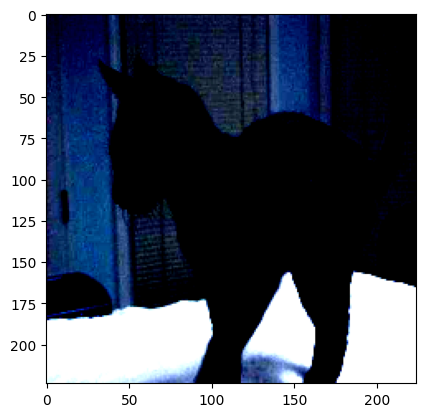

In [19]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [21]:
def get_model():
  model = models.vgg16(pretrained=True)

  for param in model.parameters():
    param.requires_grad = False    # Freeze prameter updates during backpropagation

  model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))  # return a feature map of size 1x1 instead of 7x7

  # Classifier module of the model
  model.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid()
      )

  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model.to(device), loss_fn, optimizer

In [26]:
model, criterion, optimizer = get_model()
summary(model, input_size = (3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

**Train on a batch of data**

In [27]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

**Function to calculate accuray on a batch of data**

In [28]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

**Function to fetch the data loaders**

In [29]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [30]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

**Model Training**

In [36]:
train_losses, train_accuracies = [], []
val_accuracies = []

for epoch in range(5):
    print(f" Epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Trainig Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy*100:.4f}%")
    print(f"--------------------------------- Validation Accuracy: {val_epoch_accuracy * 100:.4f}%")


 Epoch 1/5
Trainig Loss: 0.0043, Training Accuracy: 100.0000%
--------------------------------- Validation Accuracy: 98.2863%
 Epoch 2/5
Trainig Loss: 0.0035, Training Accuracy: 100.0000%
--------------------------------- Validation Accuracy: 98.1855%
 Epoch 3/5
Trainig Loss: 0.0028, Training Accuracy: 100.0000%
--------------------------------- Validation Accuracy: 98.1855%
 Epoch 4/5
Trainig Loss: 0.0026, Training Accuracy: 100.0000%
--------------------------------- Validation Accuracy: 98.2863%
 Epoch 5/5
Trainig Loss: 0.0020, Training Accuracy: 100.0000%
--------------------------------- Validation Accuracy: 98.1855%


**Plot Training and Validation Accuracy**

<ipython-input-40-efcad3b227be>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


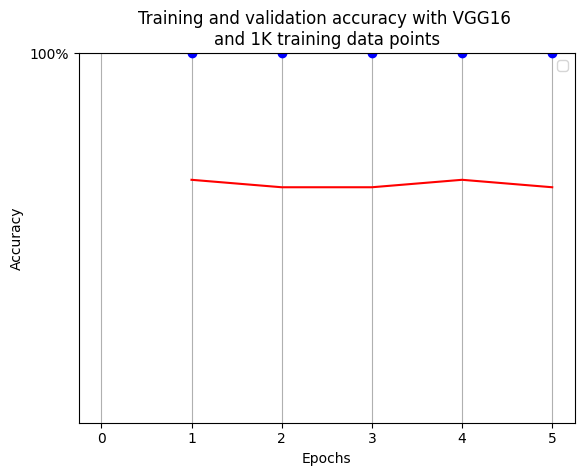

In [40]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

plt.plot(epochs, train_accuracies, 'bo', 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', 'Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()